In [1]:
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())
from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv
from motion_imitation.envs.humanoid_ia import HumanoidImpAwareEnv
from motion_imitation.utils.config import Config 
import matplotlib.pyplot as plt
import glfw




In [5]:
out_name = f'0202_wo_phase_skeleton.mp4'
video_dir = f'./out/videos/normal_hw'

frames_to_video(f'{video_dir}/frame_skeleton',video_dir, 30, out_name)


In [43]:
cfg = Config('0202', False, create_dirs=False)

cfg.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)
env.model_dm




Scaling the model size to 1.75 meters
0 0 0
0.0000 0.0000 -0.0240
0.3714 -0.0990 -0.8442
-0.3714 -0.0990 -0.8442
0.0006 0.0081 0.1232
0.0011 0.0071 0.2808
-0.0023 -0.0083 0.5472
0.6814 -0.0149 0.4121
-0.6814 -0.0149 0.4121
Saving the scaled model to /home/xliu227/Github/RFC/khrylib/assets/mujoco_models/mocap_v2_height_scaled.xml
lowerTrunk: 11.617500000000001
mass of Pelvis: 8.8725
mass of UpperLeg: 10.8525
mass of LowerLeg: 3.4274999999999998
mass of Toe: 0.9974999999999999
mass of UpperLeg: 10.8525
mass of LowerLeg: 3.4274999999999998
mass of Toe: 0.9974999999999999
mass of UpperTrunk: 3.9225
mass of LowerTrunk: 11.617500000000001
mass of Neck: 5.1075
mass of Shoulder: 3.9225
mass of UpperArm: 1.9725000000000001
mass of ForeArm: 1.125
mass of Hand: 0.4425
mass of Shoulder: 3.9225
mass of UpperArm: 1.9725000000000001
mass of ForeArm: 1.125
mass of Hand: 0.4425
Scaled model is saved at  /home/xliu227/Github/RFC/khrylib/assets/mujoco_models/mocap_v2_all_scacled.xml
scaled height: 1.7500

((75, 39), (74, 39))

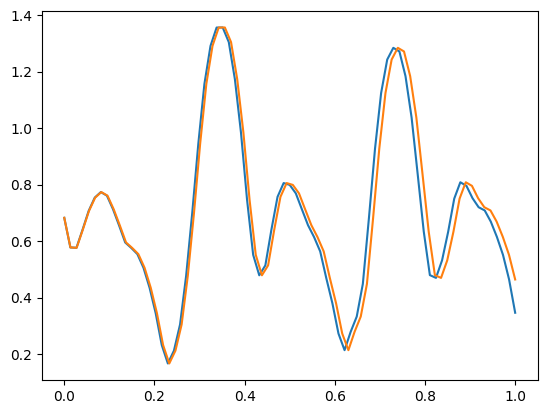

In [72]:
import mujoco
sim = env.sim
model = sim.model
# Example trajectory data
epo = env.get_expert_attr('qpos', env.get_expert_index(0)).copy()
t = 0
epos = []
for t in range(env.expert['len']): 
    epo = env.get_expert_attr('qpos', env.get_expert_index(t)).copy()
   # print(epos.shape)
    if env.expert['meta']['cyclic']:
        init_pos = env.expert['init_pos']
        cycle_h = env.expert['cycle_relheading']
        cycle_pos = env.expert['cycle_pos']
        epo[:3] = quat_mul_vec(cycle_h, epo[:3] - init_pos) + cycle_pos
        epo[3:7] = quaternion_multiply(cycle_h, epo[3:7])
    epos.append(epo)
    



qpos_trajectory =  np.array(epos) # Joint positions



# Skip rate
skip_rate = 1
# Perform linear interpolation
interpolated_trajectory = []
for i in range(len(qpos_trajectory) - 1):
    start = qpos_trajectory[i]
    end = qpos_trajectory[i + 1]
    for j in range(skip_rate):
        alpha = j / skip_rate
        interpolated_point = (1 - alpha) * start + alpha * end
        interpolated_trajectory.append(interpolated_point)

interpolated_trajectory = np.array(interpolated_trajectory)
qvel_trajectory =  np.zeros([interpolated_trajectory.shape[0],38]) # Joint velocities
qacc_trajectory = np.zeros([interpolated_trajectory.shape[0],38])  # Joint accelerations

plt.plot(np.linspace(0,1, qpos_trajectory.shape[0]), qpos_trajectory[:, 10], label='qpos')
plt.plot(np.linspace(0,1, interpolated_trajectory.shape[0]), interpolated_trajectory[:, 10], label='interpolated'),

qpos_trajectory.shape, interpolated_trajectory.shape

In [ ]:



torque_estimates = generate_inverse_dynamics_torques(env, interpolated_trajectory, qvel_trajectory, qacc_trajectory)
torque_estimates.shape, qpos_trajectory.shape

knee_torques = torque_estimates[:,9]
np.max(knee_torques), np.min(knee_torques), np.mean(knee_torques), np.std(knee_torques), knee_torques.shape
# env.dt

# plt.plot(np.linspace(0,1, knee_torques.shape[0]), knee_torques/env.mass/9.81, label='knee_torque')
# plt.legend()
# knee_torques.shape

(2019.4933738100817,
 -10342.142357594323,
 -2422.8885068400464,
 3090.3554100664333,
 (1110,))

In [ ]:
print("self.body_tree = {")
for parent, children in env.body_tree.items():
    print(f"    '{parent}': {children if children else []},")
print("}")


self.body_tree = {
    'root': ['lhipjoint', 'rhipjoint', 'lowerback'],
    'lhipjoint': ['lfemur'],
    'lfemur': ['ltibia'],
    'ltibia': ['lfoot'],
    'lfoot': [],
    'rhipjoint': ['rfemur'],
    'rfemur': ['rtibia'],
    'rtibia': ['rfoot'],
    'rfoot': [],
    'lowerback': ['upperback'],
    'upperback': ['thorax'],
    'thorax': ['lowerneck'],
    'lowerneck': ['upperneck', 'lclavicle', 'rclavicle'],
    'upperneck': ['head'],
    'head': [],
    'lclavicle': ['lhumerus'],
    'lhumerus': ['lradius'],
    'lradius': ['lwrist'],
    'lwrist': [],
    'rclavicle': ['rhumerus'],
    'rhumerus': ['rradius'],
    'rradius': ['rwrist'],
    'rwrist': [],
}


In [5]:


sys.path.append("/home/xliu227/Github/human-model-generator/code/")
from write_xml import calculate_humanoid_height
sum(env.model.body_mass), calculate_humanoid_height("/home/xliu227/Github/RFC/khrylib/assets/mujoco_models/mocap_v2_all_scacled.xml")
env.cfg.jkp, env.cfg.jkd, env.cfg.torque_lim, env.sim.data.actuator_length
# env.cfg.jkd

(array([1659.14465579, 1659.14465579, 1659.14465579, 1659.14465579,
        1327.31572464, 1327.31572464, 1327.31572464, 1659.14465579,
        1659.14465579, 1659.14465579, 1659.14465579, 1327.31572464,
        1327.31572464, 1327.31572464, 3318.28931159, 3318.28931159,
        3318.28931159,  663.65786232,  663.65786232,  663.65786232,
        1327.31572464, 1327.31572464, 1327.31572464, 1327.31572464,
        1327.31572464,  995.48679348, 1327.31572464, 1327.31572464,
        1327.31572464, 1327.31572464, 1327.31572464,  995.48679348]),
 array([331.82893116, 331.82893116, 331.82893116, 331.82893116,
        265.46314493, 265.46314493, 265.46314493, 331.82893116,
        331.82893116, 331.82893116, 331.82893116, 265.46314493,
        265.46314493, 265.46314493, 663.65786232, 663.65786232,
        663.65786232, 132.73157246, 132.73157246, 132.73157246,
        265.46314493, 265.46314493, 265.46314493, 265.46314493,
        265.46314493, 199.0973587 , 265.46314493, 265.46314493,
      

In [4]:

env_ia = HumanoidImpAwareEnv(cfg)
env.seed(cfg.seed)



body_qposaddr_list_start_index = [idxs[0] for idxs in list(env.body_qposaddr.values())]
env.knee_id = body_qposaddr_list_start_index[2]


# Example usage:
# visualize_qpos(qpos, body_qposaddr_list_start_index, body_qposaddr)



env_p = HumanoidEnvProthesis(cfg_p, cfg)
env_p.seed(cfg_p.seed)

actuators = env.model.actuator_names
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actuators_f = env_p.model.actuator_names
state_dim_f = env_p.observation_space.shape[0]
action_dim_f = env_p.action_space.shape[0]




AssertionError: The standard model file should be mocap_v2, instead it is /home/xliu227/Github/RFC/khrylib/assets/mujoco_models/mocap_v2_all_scacled.xml

In [ ]:
sum(env.sim.model.body_mass)
env.action_space.low, env.action_space.high

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], dtype=float32))

In [ ]:
env_ia.jkp, env_ia.jkd 
env_ia.jkp.shape, env_ia.jkd.shape 
bdnames, bdmass = env_ia.model.body_names, env_ia.model.body_mass #, env_ia.model.body_subtreemass  # Index 0 gives mass of entire system
{bdnames[i]: bdmass[i] for i in range(len(bdnames))}, np.allclose(np.sum(np.array(bdmass)), env_ia.model.body_subtreemass[0])  # Total mass of the system


NameError: name 'env_ia' is not defined

In [9]:
env.sim.data.actuator_length.shape, env.sim.data.actuator_force.shape

((32,), (32,))

In [ ]:
action_dim, state_dim
env.cfg.residual_force_torque, env.vf_dim
env_p.sim.model.body_names
# Print the body tree in the desired format


NameError: name 'action_dim' is not defined

In [ ]:
"""load learner policy"""
policy_net = PolicyGaussian(MLP(state_dim, cfg.policy_hsize, cfg.policy_htype), action_dim, log_std=cfg.log_std, fix_std=cfg.fix_std)
value_net = Value(MLP(state_dim, cfg.value_hsize, cfg.value_htype))
cp_path = '%s/iter_%04d.p' % (cfg.model_dir, 800)
logger.info('loading model from checkpoint: %s' % cp_path)
model_cp = pickle.load(open(cp_path, "rb"))
policy_net.load_state_dict(model_cp['policy_dict'])
value_net.load_state_dict(model_cp['value_dict'])
running_state = model_cp['running_state']

loading model from checkpoint: results/motion_im/0202/models/iter_0800.p
loading model from checkpoint: results/motion_im/0202/models/iter_0800.p


In [ ]:
# change based on osl default controller
phase_list = ['e_stance', 'l_stance', 'e_swing', 'l_swing']
joint_list = ['knee', 'ankle', 'threshold']
# gain_list =  ['knee_stiffness', 'knee_damping', 'ankle_stiffness', 'ankle_damping', 'load', 'knee_angle', 'knee_vel', 'ankle_angle']
n_sets = env_p.OSL_CTRL.n_sets

for phase_name in phase_list: 
    env_p.OSL_CTRL.set_osl_param( phase_name, 'gain',  'ankle_stiffness', 0 , mode=0)
env_p.sim.model.get_joint_qvel_addr("knee")

9

In [ ]:
env_p.get_full_obs() - env.get_full_obs(), env.get_full_obs()[9], env_p.get_full_obs()[9], env.get_full_obs()[47], env_p.get_full_obs()[47]

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.16615273,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.63407324,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
env.body_qposaddr, env_p.body_qposaddr
state_p = env_p.reset()
state = env.reset() 
env_p.get_osl_sens()
env_p.compute_torque(np.zeros(30)).shape, env.compute_torque(np.zeros(32)).shape


((30,), (32,))

In [ ]:
env_p.sim.model.actuator_names, env_p.sim.model.actuator_actadr

AttributeError: 'mujoco_py.cymj.PyMjModel' object has no attribute 'actuator_actadr'

In [ ]:
env_p.sim.model.jnt_qposadr, env.sim.model.jnt_qposadr

(array([ 0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
       dtype=int32),
 array([ 0,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
       dtype=int32))

In [ ]:
env_p.sim.model.body_dofadr, env.sim.model.body_dofadr, env.sim.model.body_names

(array([-1,  0, -1,  6,  9, 10, -1, 11, 14, 15, -1, 18, -1, 21, -1, -1, 24,
        26, 29, -1, 30, 32, 35, -1], dtype=int32),
 array([-1,  0, -1,  6,  9, 10, -1, 13, 16, 17, -1, 20, -1, 23, -1, -1, 26,
        28, 31, -1, 32, 34, 37, -1], dtype=int32),
 ('world',
  'root',
  'lhipjoint',
  'lfemur',
  'ltibia',
  'lfoot',
  'rhipjoint',
  'rfemur',
  'rtibia',
  'rfoot',
  'lowerback',
  'upperback',
  'thorax',
  'lowerneck',
  'upperneck',
  'head',
  'lclavicle',
  'lhumerus',
  'lradius',
  'lwrist',
  'rclavicle',
  'rhumerus',
  'rradius',
  'rwrist'))

In [ ]:
env_p.sim.model.body_jntadr, env.sim.model.body_jntadr, env.sim.model.body_names

(array([-1,  0, -1,  1,  4,  5, -1,  6,  9, 10, -1, 13, -1, 16, -1, -1, 19,
        21, 24, -1, 25, 27, 30, -1], dtype=int32),
 array([-1,  0, -1,  1,  4,  5, -1,  8, 11, 12, -1, 15, -1, 18, -1, -1, 21,
        23, 26, -1, 27, 29, 32, -1], dtype=int32),
 ('world',
  'root',
  'lhipjoint',
  'lfemur',
  'ltibia',
  'lfoot',
  'rhipjoint',
  'rfemur',
  'rtibia',
  'rfoot',
  'lowerback',
  'upperback',
  'thorax',
  'lowerneck',
  'upperneck',
  'head',
  'lclavicle',
  'lhumerus',
  'lradius',
  'lwrist',
  'rclavicle',
  'rhumerus',
  'rradius',
  'rwrist'))

key load, thres 119.19312174097098, cond above Transitioning to  e_stance
key load, thres 74.49570108810686, cond above Transitioning to  l_stance
key load, thres 29.798280435242745, cond below Transitioning to  e_swing
key knee_vel, thres 0.05235987755982989, cond below Transitioning to  l_swing
key load, thres 119.19312174097098, cond above Transitioning to  e_stance
key load, thres 74.49570108810686, cond above Transitioning to  l_stance
key load, thres 29.798280435242745, cond below Transitioning to  e_swing
key knee_vel, thres 0.05235987755982989, cond below Transitioning to  l_swing
key knee_angle, thres 0.5235987755982988, cond below Transitioning to  e_stance
key ankle_angle, thres 0.10471975511965978, cond above Transitioning to  l_stance
key load, thres 29.798280435242745, cond below Transitioning to  e_swing
key knee_vel, thres 0.05235987755982989, cond below Transitioning to  l_swing
key knee_angle, thres 0.5235987755982988, cond below Transitioning to  e_stance
key ankle_a

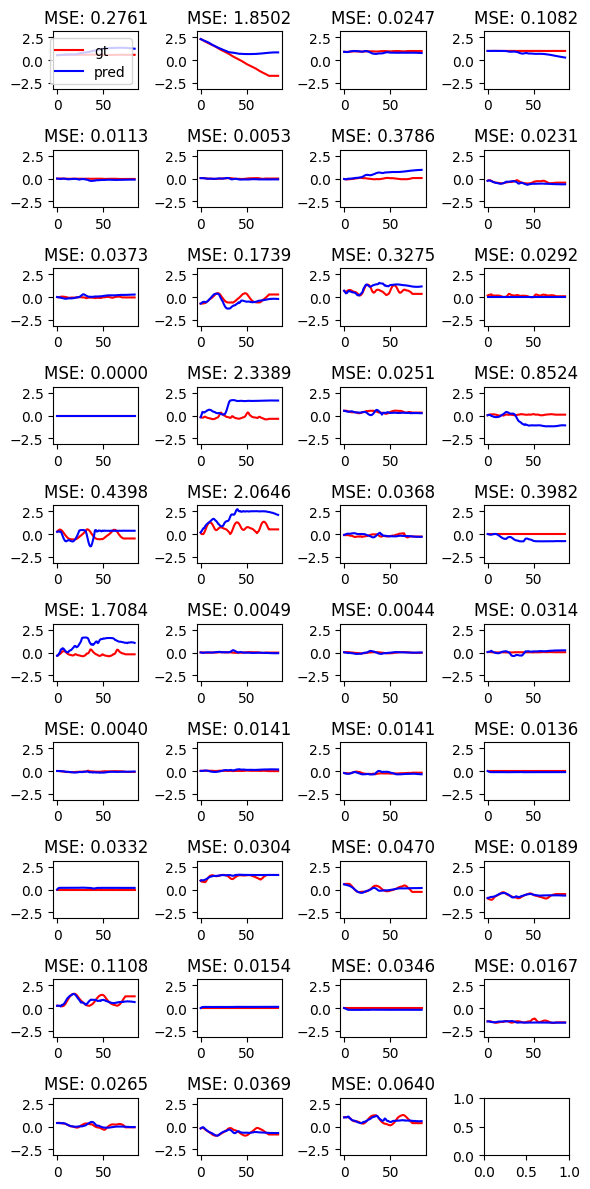

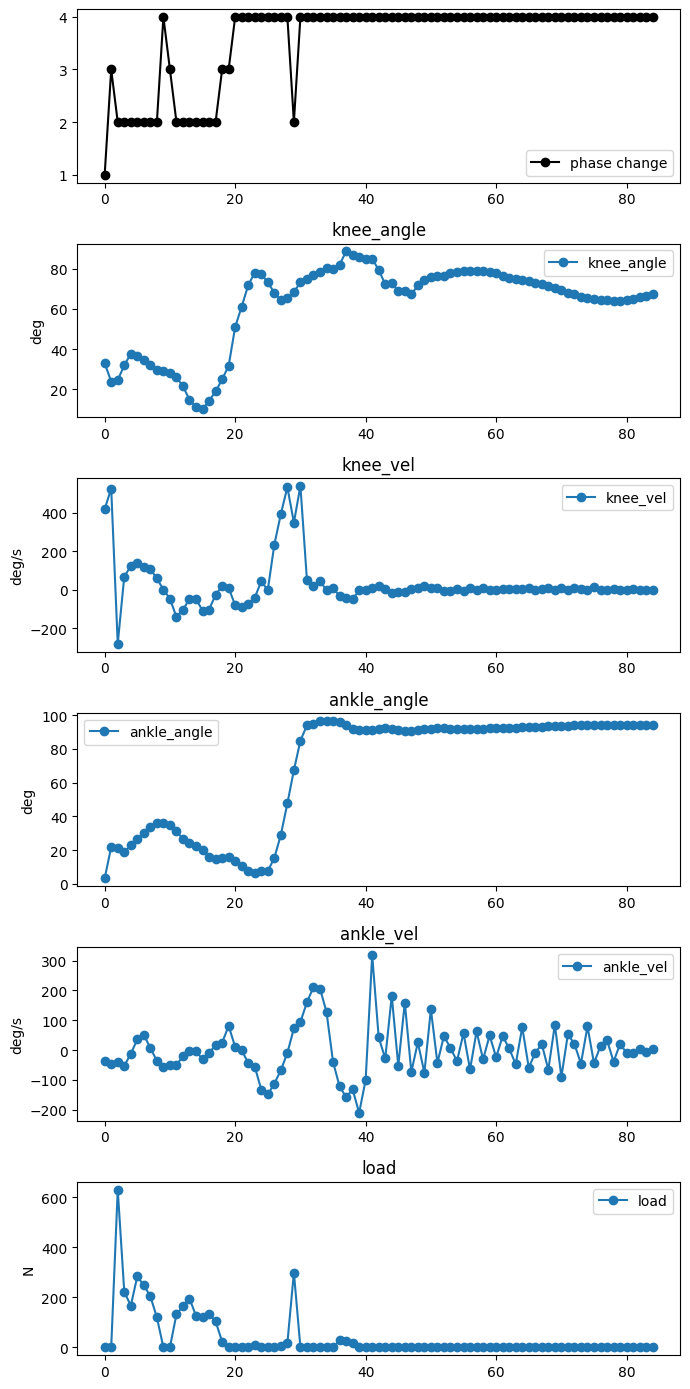

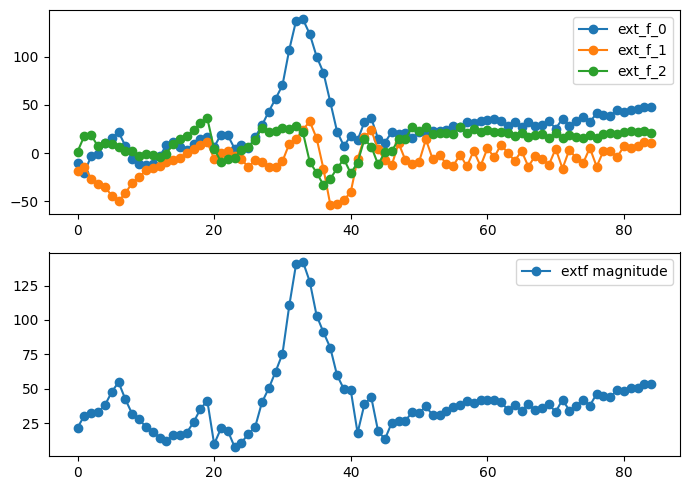

Creating window glfw


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


T: 15
T: 20
T: 30
T: 40
T: 50
T: 60
T: 1
0/85, 0.929
T: 2
T: 4
T: 6
T: 8
T: 10
T: 12
T: 15
T: 20
T: 30
1/85, 0.884
T: 40
T: 50
T: 60
T: 1
T: 2
T: 4
T: 6
2/85, 0.947
T: 8
T: 10
T: 12
T: 15
T: 20
T: 30
T: 40
T: 50
T: 60
3/85, 0.886
T: 1
T: 2
T: 4
T: 6
T: 8
T: 10
4/85, 0.895
5/85, 0.907
6/85, 0.949
7/85, 0.964
8/85, 0.908
9/85, 0.889
10/85, 0.864
11/85, 0.894
12/85, 0.898


NameError: name 'exit' is not defined

In [ ]:

vis = MyVisulizerFK(f'mocap_v2_vis.xml')
# vis.num_fr

vis.record_video(preview = False)


In [ ]:
np.sum(env_p.model.body_mass)



30.37541328770922

In [ ]:
vis.data['pred'][vis.fr].shape

(39,)

In [ ]:
env_p.OSL_CTRL.OSL_PARAM_LIST

{0: {'e_stance': {'gain': {'knee_stiffness': 99.372,
    'knee_damping': 3.18,
    'knee_target_angle': 0.08726646259971647,
    'ankle_stiffness': 0,
    'ankle_damping': 0,
    'ankle_target_angle': -0.03490658503988659},
   'threshold': {'load': (74.49570108810686, 'above'),
    'ankle_angle': (0.10471975511965978, 'above')}},
  'l_stance': {'gain': {'knee_stiffness': 99.372,
    'knee_damping': 1.272,
    'knee_target_angle': 0.13962634015954636,
    'ankle_stiffness': 0,
    'ankle_damping': 0.063,
    'ankle_target_angle': -0.3490658503988659},
   'threshold': {'load': (29.798280435242745, 'below')}},
  'e_swing': {'gain': {'knee_stiffness': 39.749,
    'knee_damping': 0.063,
    'knee_target_angle': 1.0471975511965976,
    'ankle_stiffness': 0,
    'ankle_damping': 0,
    'ankle_target_angle': 0.4363323129985824},
   'threshold': {'knee_angle': (0.8726646259971648, 'above'),
    'knee_vel': (0.05235987755982989, 'below')}},
  'l_swing': {'gain': {'knee_stiffness': 15.899,
    'k

In [ ]:
thresholds = [env_p.OSL_CTRL.osl_state_list[p].get_thresholds() for p in env_p.OSL_CTRL.osl_state_list.keys()]
phases = list(env_p.OSL_CTRL.osl_state_list.keys())

for phase, threshold in zip(phases, thresholds):
    print(f"Phase: {phase}")
    for key, value in threshold.items():
        if 'angle' in key or 'vel' in key:
            angle_in_degrees = np.degrees(value[0])
            print(f"{key}: ({angle_in_degrees:.2f} degrees, {value[1]})")
        else:
            print(f"{key}: {value}")

Phase: e_stance
load: (74.49570108810686, 'above')
ankle_angle: (6.00 degrees, above)
Phase: l_stance
load: (29.798280435242745, 'below')
Phase: e_swing
knee_angle: (50.00 degrees, above)
knee_vel: (3.00 degrees, below)
Phase: l_swing
load: (119.19312174097098, 'above')
knee_angle: (30.00 degrees, below)
